# util

In [0]:
# coding: utf-8
import numpy as np


def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.

    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


# functions

In [0]:
# coding: utf-8
import numpy as np


def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error_one(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

    
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)


# gradient

In [3]:
# coding: utf-8
import numpy as np

def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

if __name__ == '__main__':
    f_xx = lambda x: x*x
    print(_numerical_gradient_1d(f_xx, np.array([3])))

[25000]


# layers

In [0]:
# coding: utf-8
import numpy as np


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx


class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


# two layer net

In [0]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정



class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads


# multi layer

In [0]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict


class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


# simple net

In [7]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(dW)


[[ 0.15053442  0.14911474 -0.29964916]
 [ 0.22580164  0.22367211 -0.44947375]]


# data 만들기

In [0]:
import math
import random
import matplotlib.pyplot as plt


# y = w * x + b 함수
def myfunc(x):
  y = math.cos(x) + math.sin(x) * math.sin(x)
  noise = random.random() * 0.1    # Noise
  return y + noise

In [0]:
# random.random() -- (0.0 ~ 1.0)
NUM_DATA = 50      # 데이터 갯수
XVALUE = 5          # X값의 범위 (0.0 ~ 5.0)

x_train = [random.random() * XVALUE for i in range(NUM_DATA)]
x_train.sort()        # sorting
t_train = [myfunc(x) for x in x_train]

x_test = [random.random() * XVALUE for i in range(50)]
t_test = [myfunc(x) for x in x_test]



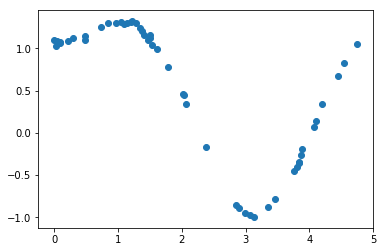

In [10]:
fig, ax = plt.subplots()
ax.scatter(x_train, t_train, label='actual')
plt.show()

# train two layer net

-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train acc, test acc | 1.0, 1.0
-9.999999505838704e-08
train

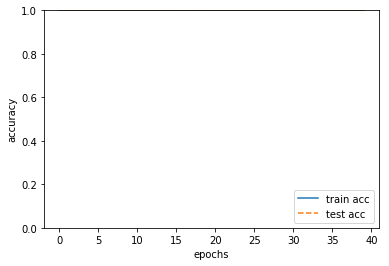

In [13]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt

# 데이터 읽기
#(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

x_train, t_train = np.array(x_train).reshape(-1, 1), np.array(t_train).reshape(-1, 1)
x_test, t_test = np.array(x_test).reshape(-1, 1), np.array(t_test).reshape(-1, 1)


network = TwoLayerNet(input_size=1, hidden_size=2, output_size=1)

# 하이퍼파라미터
iters_num = 200  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 10   # 미니배치 크기
learning_rate = 0.05

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    #grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(loss)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
